# Machine Learning Assignment 2 - Model Training & Evaluation
## M.Tech (AIML/DSE) - BITS Pilani

This notebook implements 6 classification models and evaluates them using multiple metrics.

## Step 1: Install Required Libraries

In [1]:
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn -q

## Step 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report
)
import pickle
import warnings
warnings.filterwarnings('ignore')

## Step 3: Load Dataset

**Dataset Choice: Heart Disease UCI Dataset**

- **Source**: UCI Machine Learning Repository / Kaggle
- **Features**: 13 features (age, sex, chest pain type, blood pressure, cholesterol, etc.)
- **Target**: Binary classification (presence/absence of heart disease)
- **Instances**: 303 records

**Note**: You can replace this with any dataset meeting the criteria:
- Minimum 12 features
- Minimum 500 instances

Popular alternatives:
- Breast Cancer Wisconsin Dataset
- Bank Marketing Dataset
- Credit Card Fraud Detection
- Adult Income Dataset

In [3]:
# Option 1: Load from Kaggle (if you have kaggle.json configured)
# !kaggle datasets download -d ronitf/heart-disease-uci
# !unzip heart-disease-uci.zip

# Option 2: Load from URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df = pd.read_csv(url, names=column_names, na_values='?')

# Option 3: Upload your own dataset
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv(list(uploaded.keys())[0])

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset Shape: (303, 14)

First few rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## Step 4: Data Preprocessing

In [4]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Handle missing values
df = df.dropna()

# Convert target to binary (0 = no disease, 1 = disease present)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print(f"\nTarget Distribution:")
print(df['target'].value_counts())

# Dataset info
df.info()

Missing Values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Target Distribution:
target
0    160
1    137
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  target    29

In [5]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (237, 13)
Test set size: (60, 13)


## Step 5: Define Evaluation Function

In [6]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model and return all required metrics
    """
    # Predictions
    y_pred = model.predict(X_test)

    # For AUC, we need probability scores
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = y_pred

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'AUC': round(roc_auc_score(y_test, y_pred_proba), 4),
        'Precision': round(precision_score(y_test, y_pred, average='binary'), 4),
        'Recall': round(recall_score(y_test, y_pred, average='binary'), 4),
        'F1': round(f1_score(y_test, y_pred, average='binary'), 4),
        'MCC': round(matthews_corrcoef(y_test, y_pred), 4)
    }

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    return metrics, cm, y_pred

## Step 6: Train and Evaluate All Models

In [7]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Store results
results = []
trained_models = {}
confusion_matrices = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print('='*60)

    # Train
    model.fit(X_train_scaled, y_train)

    # Evaluate
    metrics, cm, y_pred = evaluate_model(model, X_test_scaled, y_test, name)
    results.append(metrics)
    trained_models[name] = model
    confusion_matrices[name] = cm

    # Print metrics
    print(f"\nMetrics for {name}:")
    for key, value in metrics.items():
        if key != 'Model':
            print(f"  {key}: {value}")

print("\n" + "="*60)
print("All models trained successfully!")
print("="*60)


Training Logistic Regression...

Metrics for Logistic Regression:
  Accuracy: 0.8333
  AUC: 0.9498
  Precision: 0.8462
  Recall: 0.7857
  F1: 0.8148
  MCC: 0.6652

Training Decision Tree...

Metrics for Decision Tree:
  Accuracy: 0.6833
  AUC: 0.6786
  Precision: 0.68
  Recall: 0.6071
  F1: 0.6415
  MCC: 0.3614

Training kNN...

Metrics for kNN:
  Accuracy: 0.8833
  AUC: 0.9492
  Precision: 0.92
  Recall: 0.8214
  F1: 0.8679
  MCC: 0.768

Training Naive Bayes...

Metrics for Naive Bayes:
  Accuracy: 0.8833
  AUC: 0.9375
  Precision: 0.8889
  Recall: 0.8571
  F1: 0.8727
  MCC: 0.7655

Training Random Forest...

Metrics for Random Forest:
  Accuracy: 0.8667
  AUC: 0.9414
  Precision: 0.8846
  Recall: 0.8214
  F1: 0.8519
  MCC: 0.7326

Training XGBoost...

Metrics for XGBoost:
  Accuracy: 0.8667
  AUC: 0.8917
  Precision: 0.8846
  Recall: 0.8214
  F1: 0.8519
  MCC: 0.7326

All models trained successfully!


## Step 7: Results Comparison Table

In [8]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC']]

print("\n" + "="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Save to CSV
results_df.to_csv('model_comparison.csv', index=False)
print("\nResults saved to 'model_comparison.csv'")


MODEL COMPARISON TABLE
              Model  Accuracy    AUC  Precision  Recall     F1    MCC
Logistic Regression    0.8333 0.9498     0.8462  0.7857 0.8148 0.6652
      Decision Tree    0.6833 0.6786     0.6800  0.6071 0.6415 0.3614
                kNN    0.8833 0.9492     0.9200  0.8214 0.8679 0.7680
        Naive Bayes    0.8833 0.9375     0.8889  0.8571 0.8727 0.7655
      Random Forest    0.8667 0.9414     0.8846  0.8214 0.8519 0.7326
            XGBoost    0.8667 0.8917     0.8846  0.8214 0.8519 0.7326

Results saved to 'model_comparison.csv'


## Step 8: Visualize Results

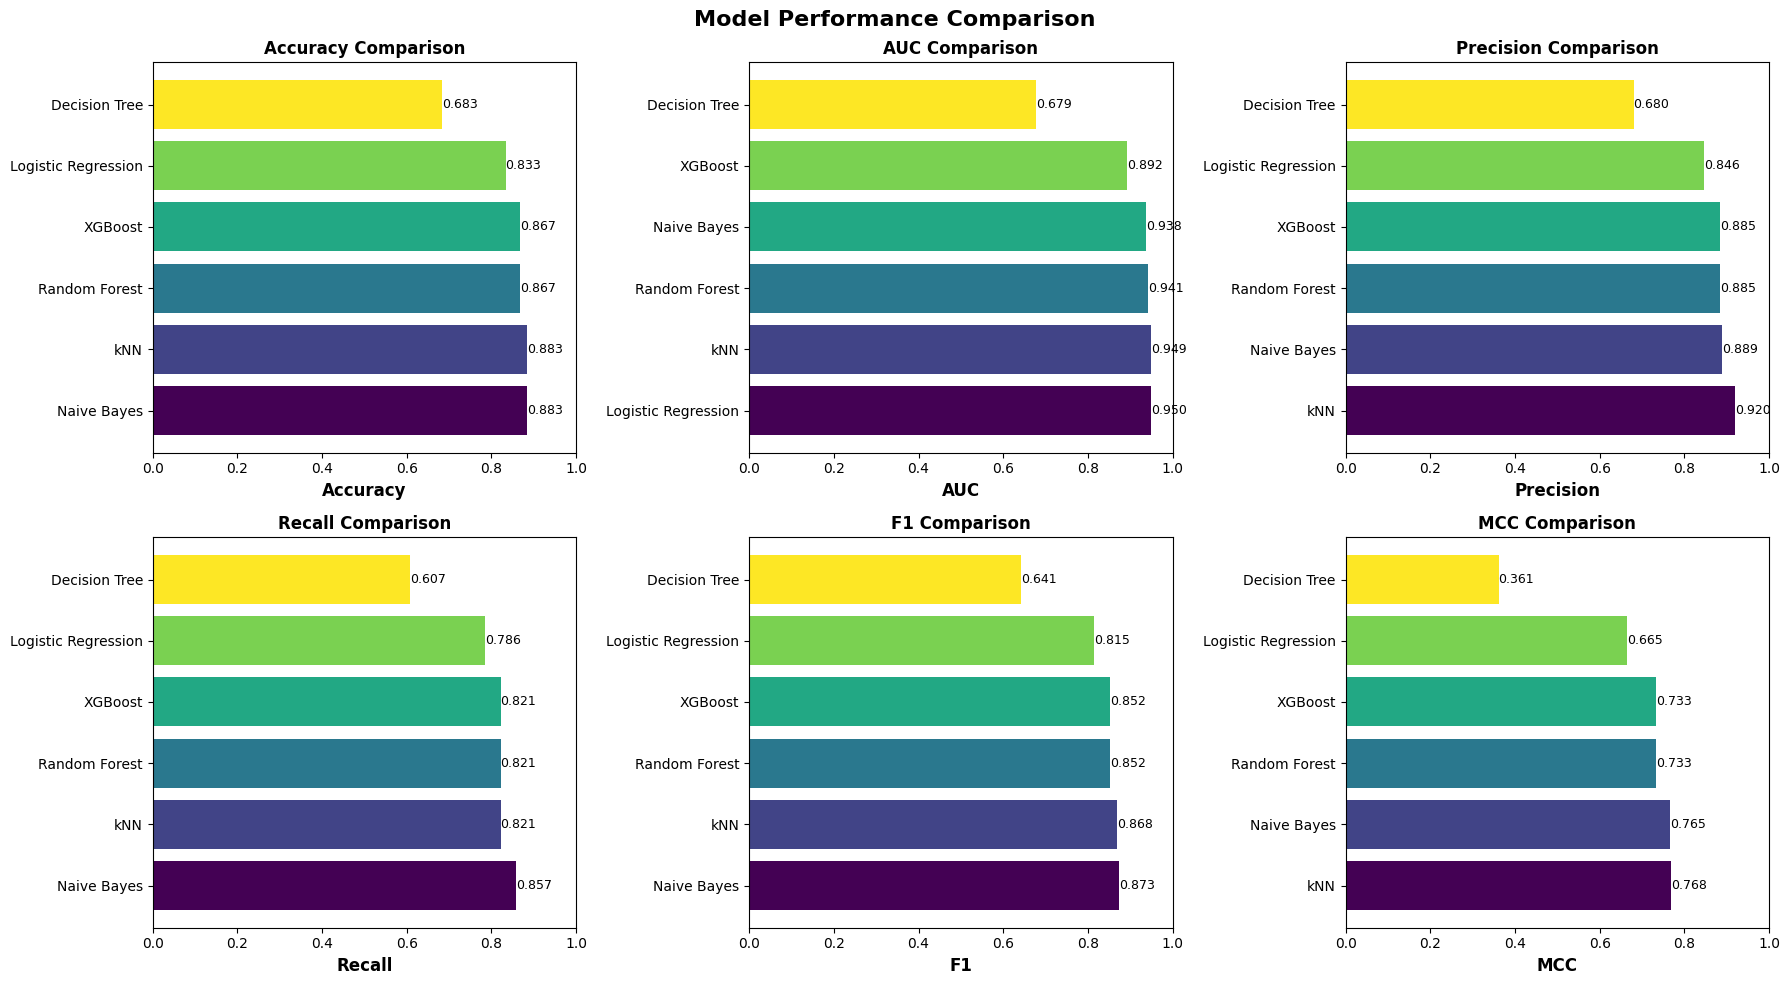

Visualization saved as 'model_comparison.png'


In [9]:
# Plot comparison of all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC']
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    data = results_df.sort_values(metric, ascending=False)
    bars = ax.barh(data['Model'], data[metric], color=plt.cm.viridis(np.linspace(0, 1, len(data))))
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1])

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'model_comparison.png'")

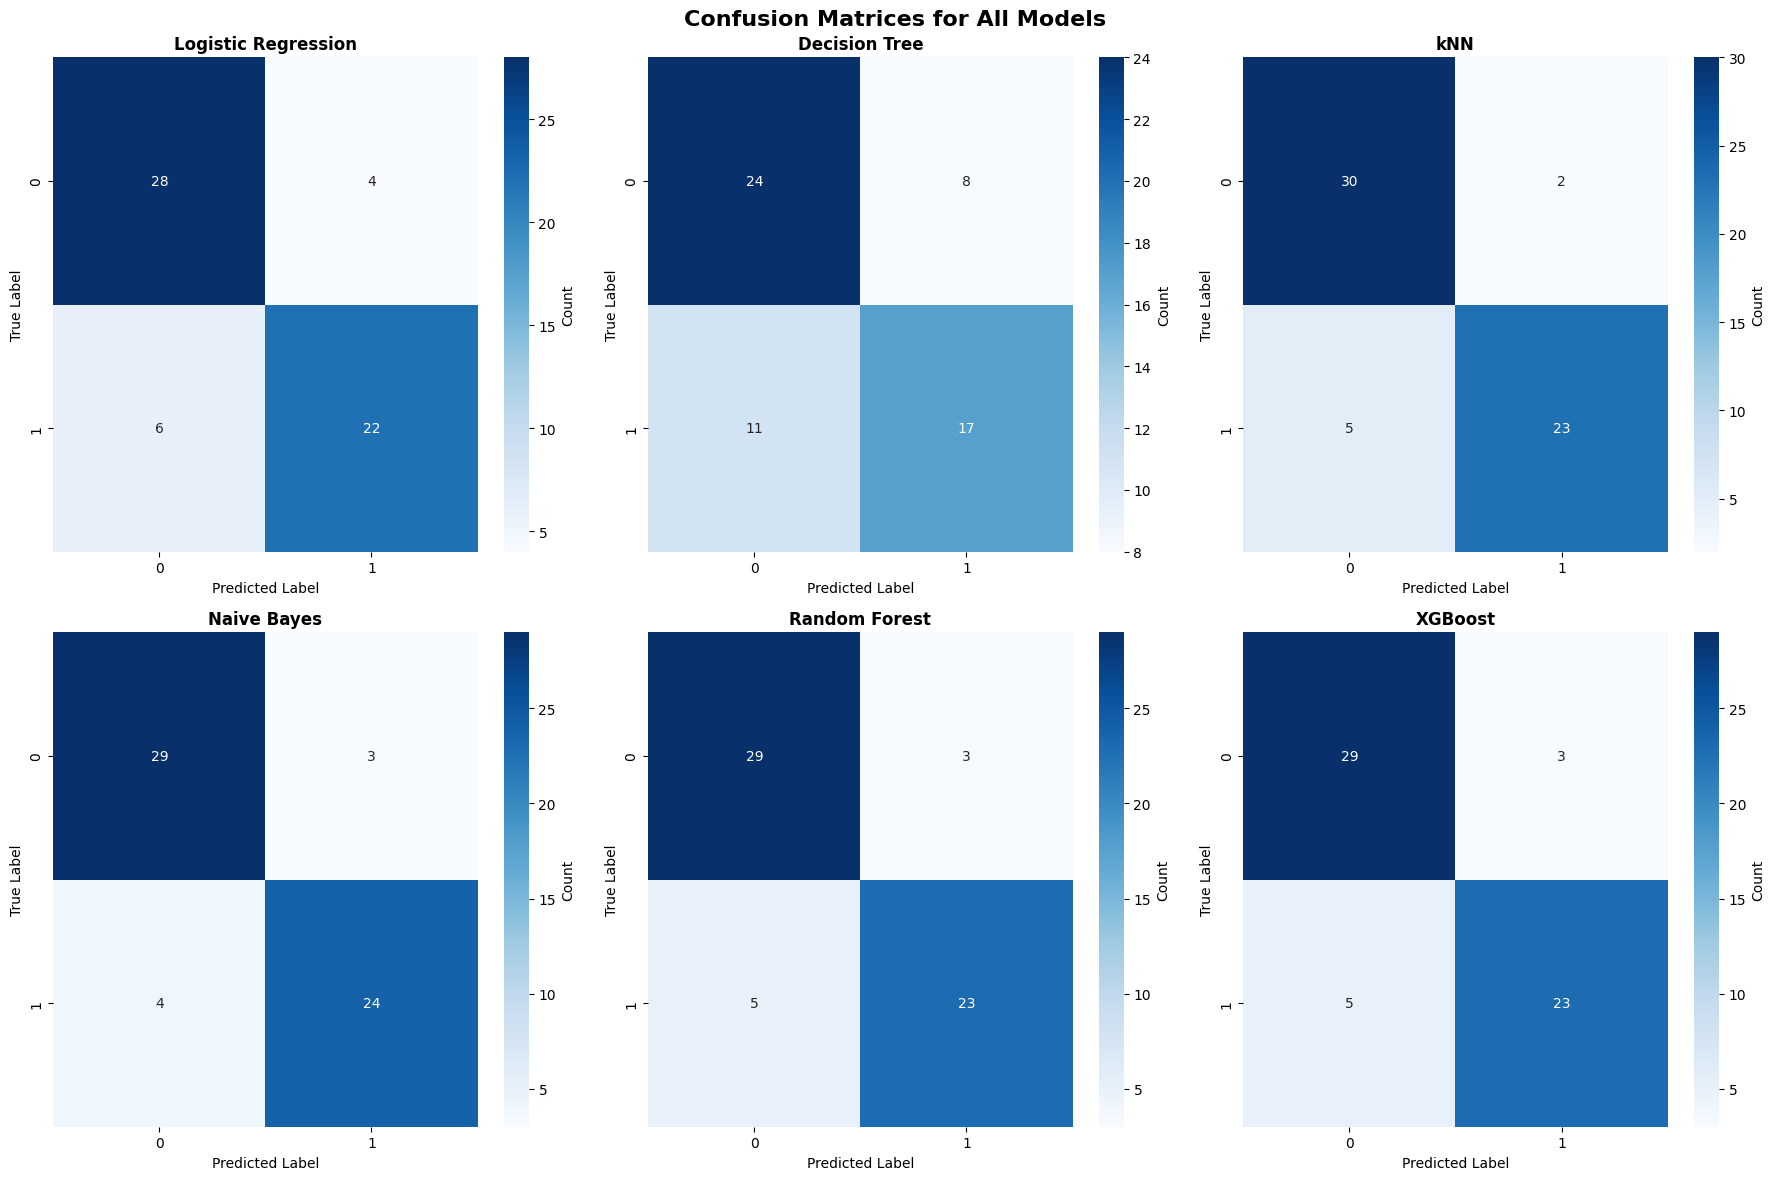

Confusion matrices saved as 'confusion_matrices.png'


In [10]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, (name, cm) in enumerate(confusion_matrices.items()):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Count'})
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices saved as 'confusion_matrices.png'")

## Step 9: Save Models and Scaler

In [11]:
# Create model directory
import os
os.makedirs('models', exist_ok=True)

# Save all trained models
for name, model in trained_models.items():
    filename = f"models/{name.lower().replace(' ', '_')}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved: {filename}")

# Save scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved: models/scaler.pkl")

# Save feature names
with open('models/feature_names.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)
print("Saved: models/feature_names.pkl")

Saved: models/logistic_regression.pkl
Saved: models/decision_tree.pkl
Saved: models/knn.pkl
Saved: models/naive_bayes.pkl
Saved: models/random_forest.pkl
Saved: models/xgboost.pkl
Saved: models/scaler.pkl
Saved: models/feature_names.pkl


## Step 10: Save Test Data for Streamlit App

In [12]:
# Save test data
test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv('test_data.csv', index=False)
print(f"Test data saved: {test_data.shape}")
print("File: test_data.csv")

Test data saved: (60, 14)
File: test_data.csv


## Step 11: Download All Files for GitHub Upload

In [13]:
# Create a zip file with all necessary files
!zip -r ml_assignment_2.zip models/ *.csv *.png *.ipynb

# Download the zip file
from google.colab import files
files.download('ml_assignment_2.zip')

print("\n" + "="*60)
print("All files packaged successfully!")
print("="*60)
print("\nDownload complete. Extract the zip file and upload to GitHub.")

	zip warning: name not matched: *.ipynb
  adding: models/ (stored 0%)
  adding: models/logistic_regression.pkl (deflated 28%)
  adding: models/decision_tree.pkl (deflated 72%)
  adding: models/random_forest.pkl (deflated 84%)
  adding: models/knn.pkl (deflated 76%)
  adding: models/feature_names.pkl (deflated 17%)
  adding: models/scaler.pkl (deflated 20%)
  adding: models/xgboost.pkl (deflated 79%)
  adding: models/naive_bayes.pkl (deflated 16%)
  adding: model_comparison.csv (deflated 41%)
  adding: test_data.csv (deflated 77%)
  adding: confusion_matrices.png (deflated 36%)
  adding: model_comparison.png (deflated 30%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All files packaged successfully!

Download complete. Extract the zip file and upload to GitHub.
